# CAB330 Case Study 1: Students

Class: CAB330

Students: 

- Christopher Ayling | 9713581 | christopher.ayling@connect.qut.edu.au
- Benjamin Saljooghi | 9448233 | benjamin.saljooghi@connect.qut.edu.au
- Jordi Smit | 10294139 | jordi.smit@connect.qut.edu.au

Due Date: 9th September 2018

Project Demo: Week 8 Wednesday Lab

Weighting: 25%

---
## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Manipulating Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from collections import defaultdict

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, Image
import graphviz
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# Algorithms
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

In [3]:
randomSeed = 330
np.random.seed(randomSeed)

---
## Data Loading

In [4]:
students = pd.read_csv("./STUDENT.csv")
students.head()

rows, columns = students.shape; rows, columns

(1044, 35)

---
## Task 1. Data Selection and Distribution. (4 marks)

### Variable Descriptions

The following information would assist you in assigning the variables roles.

- There are three target variables namely, G1, G2 and G3, with different types. Choose the target that suits best according to the given task.
- Identify if the variable is an input variable or a supplementary variable.
- Data transformation is required for a few input variables to get improved accuracy

### 1.1 Proportion of Students Who Will Pass

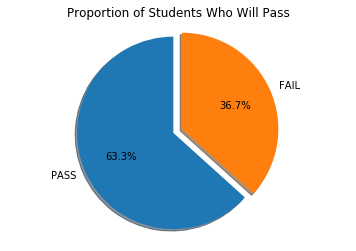

In [5]:
G3_counts = students['G3'].value_counts()
plt.pie(G3_counts, labels=G3_counts.index, startangle=90, shadow=True, explode=(0, 0.1), autopct='%1.1f%%')
plt.title("Proportion of Students Who Will Pass")
plt.axis('equal')
plt.show()

### 1.2 Data Cleaning

In [6]:
cleaned = students.copy()

# impute age NAs with mean
cleaned['age'].fillna(cleaned['age'].mean(), inplace=True)

# impute reason NAs with unknown value because else it will be read as float instead of a string, which cause trouble with the hot one transformation.
cleaned['reason'].fillna("-", inplace=True)

# impute school NAs with unknown value because else it will be read as float instead of a string, which cause trouble with the hot one transformation..
cleaned['school'].fillna("-", inplace=True)

# drop unused columns
cleaned.drop(columns=["id", "InitialName"], inplace=True)

#TODO maby better to remove missing target variable?
# impute G1 NAs with mean
cleaned['G1'].fillna(cleaned['G1'].mean(), inplace=True)

# impute G2 NAs with mean
cleaned['G2'].fillna(cleaned['G2'].mean(), inplace=True)

#TODO Should we also check for outliers or inconsistencies?

### 1.3 Level of Measurement

In [7]:
descriptions = {
    "id": ["student's id", False, False, 'nominal', False, "Integer"],
    "InitialName": ["student's initial", False, False, 'nominal', False,  "String"],
    "school": ["student's school name", True, True, 'nominal', False, "String"],
    "sex": ["student's sex", True, True, 'nominal', False, "Char"],
    "age": ["student's age", True, True, 'numerical', False, "Integer"],
    "address": ["student's home address type", True, True, 'nominal', False, "Char"],
    "famsize": ["family size (≤ 3 or > 3)", True, True, 'ordinal', False, "String"],
    "Pstatus": ["parent's cohabitation status (living together or apart)", True, True, 'nominal', False, "Char"],
    "Medu": ["mother’s education(0 – none, 1 – primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)", True, True, 'ordinal',False, "Integer"],
    "Fedu": ["father’s education(0 – none, 1 – primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)", True, True, 'ordinal', False, "Integer"],
    "Mjob": ["mother's job", True, True, 'nominal',False, "String"],
    "Fjob": ["father's job", True, True, 'nominal',False, "String"],
    "reason": ["reason to choose this school", True, True, 'nominal',False, "String"],
    "guardian": ["student's guardian", True, True, 'nominal',False, "String"],
    "traveltime": ["home to school travel time (1 – < 15 min., 2 – 15 to 30 min., 3 – 30 min. to 1 hour or 4 – > 1 hour)", True, True, 'ordinal',False, "Integer"],
    "studytime": ["weekly study time (1 – < 2 hours, 2 – 2 to 5 hours, 3 – 5 to 10 hours or 4 – > 10 hours)", True, True, 'ordinal',False, "Integer"],
    "failures": ["number of past class failures(n if 1 ≤ n < 3, else 4)", True, True, 'ordinal', False, "Integer"],
    "schoolsup": ["extra educational school support (yes or no)", True, True, 'nominal', False, "String"],
    "famsup": ["family educational support (yes or no)", True, True, 'nominal', False, "String"],
    "paid": ["extra paid classes (yes or no)", True, True, 'nominal', False, "String"],
    "activities": ["extra-curricular activities (yes or no)", True, True, 'nominal', False, "String"],
    "nursery": ["attended nursery school (yes or no)", True, True, 'nominal', False, "String"],
    "higher": ["wants to take higher education (yes or no)", True, True, 'nominal', False, "String"],
    "internet": ["Internet access at home (yes or no)", True, True, 'nominal', False, "String"],
    "romantic": ["with a romantic relationship (yes or no)", True, True, 'nominal', False, "String"],
    "famrel": ["quality of family relationships (1 – very bad to 5 – excellent)", True, True, 'ordinal', False, "Integer"],
    "freetime": ["free time after school (1 – very low to 5 – very high)", True, True, 'ordinal', False, "Integer"],
    "goout": ["going out with friends (1 – very low to 5 – very high)", True, True, 'ordinal', False, "Integer"],
    "Dalc": ["workday alcohol consumption (1 – very low to 5 – very high)", True, True, 'ordinal', False, "Integer"],
    "Walc": ["weekend alcohol consumption (1 – very low to 5 – very high)", True, True, 'ordinal', False, "Integer"],
    "health": ["current health status (1 – very bad to 5 – very good)", True, True, 'ordinal',False, "Integer"],
    "absences": ["number of school absences (0 to 75)", True, True, 'numerical', False, "Integer"],
    "G1": ["first period grade (0 to 20)", True, True, 'numerical', False, "Float"],
    "G2": ["second period grade (0 to 20)", True, True, 'numerical', False, "Float"],
    "G3": ["Final result (PASS/FAIL)", True, True, 'nominal', True, "String"],
}

red = 'background-color: Tomato'
green = 'background-color: MediumSeaGreen'
blue = 'background-color: DodgerBlue'
sblue = 'background-color: SlateBlue'
violet = 'background-color: Violet'
gray = 'background-color: Lightgray'
orange = 'background-color: Orange'

def highlight_useful(val):
    """ highlight True as green, false as red """
    return '' if val is None else green if val else red

def highlight_type(val):
    """ highlight based on variable type """
    if val == 'nominal':
        return blue
    elif val == 'ordinal':
        return sblue
    elif  val == 'numerical':
        return violet
    
def highlight_target(val):
    """ highlight if target variable """
    return orange if val else gray


COLUMN_INFORMATION = pd.DataFrame.from_dict(descriptions, orient='index')
COLUMN_INFORMATION.columns = ['Description', 'For Classification', 'For Regression', 'Variable Type', 'Target', "Dtype"]
COLUMN_INFORMATION = COLUMN_INFORMATION[['Description', 'Target', 'Variable Type',  'For Classification', 'For Regression', "Dtype"]]
COLUMN_INFORMATION['Target'] = COLUMN_INFORMATION['Target'].apply(lambda cell: bool(cell))

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(
        COLUMN_INFORMATION.style.\
            applymap(highlight_useful, subset=['For Classification', 'For Regression']).\
            applymap(highlight_type, subset='Variable Type').\
            applymap(highlight_target, subset='Target')
    )

,Description,Target,Variable Type,For Classification,For Regression,Dtype
id,student's id,False,nominal,False,False,Integer
InitialName,student's initial,False,nominal,False,False,String
school,student's school name,False,nominal,True,True,String
sex,student's sex,False,nominal,True,True,Char
age,student's age,False,numerical,True,True,Integer
address,student's home address type,False,nominal,True,True,Char
famsize,family size (≤ 3 or > 3),False,ordinal,True,True,String
Pstatus,parent's cohabitation status (living together or apart),False,nominal,True,True,Char
Medu,"mother’s education(0 – none, 1 – primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)",False,ordinal,True,True,Integer
Fedu,"father’s education(0 – none, 1 – primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)",False,ordinal,True,True,Integer


### 1.4 Distribution Scheme

In [8]:
target_variables = ['G3']
features = cleaned.loc[:, cleaned.columns.difference(target_variables)]
targets = cleaned.loc[:, target_variables]

test_size = 0.2
training_size = 1.0 - test_size
X_training, X_test, Y_training, Y_test = train_test_split(features, targets, test_size=test_size, train_size=training_size, random_state=randomSeed, shuffle=False)

In [9]:
accuracy_overview = {
    "decision_tree": {},
    "regression": {},
    "neural_network": {},
}

def format_accuracy_overview(Y, predicted_Y, most_important_features):
    return {
        "precision": precision_score(Y, predicted_Y),
        "recall": recall_score(Y, predicted_Y),
        "f1": f1_score(Y, predicted_Y),
        "accuracy": accuracy_score(Y, predicted_Y),
        "ROC": roc_curve(Y, predicted_Y),
        "AUC": roc_auc_score(Y, predicted_Y),
        "most_important_features": most_important_features
    }

---
## Task 2. Predictive Modeling Using Decision Trees

(4 marks)

### 2.1 Build a decision tree using default setting. 

In [10]:
#Create a lable encoder for each of the nominal and ordinal features.
DT_label_encoders = {}
for name in descriptions:
    if ("nominal" in descriptions[name] or "ordinal" in descriptions[name]) and name in cleaned.columns.values.tolist():
        lb = preprocessing.LabelEncoder()
        #Check cleanded data for every possible class. If only done on training data it might miss some.
        lb.fit(cleaned[name].tolist())
        DT_label_encoders[name] = lb 

def transform_features(Data, encoders):
    """Transforms data based on the provided encoder"""
    Data_copy = Data.copy()
    for col_name in Data_copy.columns.values.tolist():
        if col_name in encoders:
            #Get encoder
            encoder = encoders[col_name]
            #Transform the data in this col
            col_values = Data_copy[col_name].tolist()
            Data_copy[col_name] = encoder.transform(col_values)
            
    return Data_copy

def transform_features_to_DT(Data):
    """Transforms the nominal and ordinal features into a format that can be compared by the decision tree"""
    return transform_features(Data, DT_label_encoders)

In [11]:
#Transform the training data into a format with which the decision tree can work.
X_training_decision_tree_format = transform_features_to_DT(X_training) 
Y_training_decision_tree_format = transform_features_to_DT(Y_training) 


#Create a decision tree and train it on the formated training data.
dt = DecisionTreeClassifier(random_state=randomSeed)
dt.fit(X_training_decision_tree_format, Y_training_decision_tree_format)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=330,
            splitter='best')

#### a. What is the classification accuracy on training and test datasets?

In [12]:
#Transform test data
X_test_decision_tree_format = transform_features_to_DT(X_test) 
Y_test_decision_tree_format = transform_features_to_DT(Y_test) 

#Create a dataframe to display the values.
training_score = dt.score(X_training_decision_tree_format, Y_training_decision_tree_format)
test_score = dt.score(X_test_decision_tree_format, Y_test_decision_tree_format)    
dt_preformance = pd.DataFrame([training_score, test_score], columns=target_variables, index=['Train accuracy', 'Test accuracy'])
dt_preformance

,G3
Train accuracy,1.000000
Test accuracy,0.827751


#### b. List the decision rules

In [13]:
dt_features = X_training_decision_tree_format.columns.values.tolist()
dotfile = StringIO()
export_graphviz(dt, out_file=dotfile, feature_names=dt_features)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("default_tree.png") # saved in the following file - will return True if successful

The unique decision rules:
 - G2 <= 10.45
 - G2 <-=9.55
 - G1 <= 9.75
 - goout <=0.5
 - failures <= 0.5
 - sex <= 0.5
 - G2 <= 9.35
 - Medu <= 9.35
 - goout <= 3.5
 - Dalc < 3.5
 - G1 <= 9.85
 - age <= 17.5
 - Fedu <= 1.5
 - Fjob <= 0.5
 - studytime <= 1.0
 - age <= 16.868
 - guardian <= 1.5
 - absences <= 6.0
 - absences <= 9.0
 - G1 <= 11.225
 - famrel <= 2.5
 - walc <= 0.5
 - guardian <= 0.5
 - walc <= 2.5
 - dalc <= 0.5
 - Mjob <= 1.5
 - Medu <= 1.5
 - adress <= 0.5
 - Fedu <= 2.5
 - health <= 3.0
 - school <= 1.5
 - reason <= 2.5
 - freetime <= 2.5
 - G2 <= 11.35
 - G1 <= 11.55
 - traveltime <= 0.5
 - Fjob <= 1.5
 - reason <= 0.5
 - Walc <= 3.5
 - Walc <= 0.5
 - health <= 0.5
 - G1 <= 10.85
 - reason <= 1.5
 - paid <= 0.5
 - activities <= 0.5
 - nursery <= 0.5
 - G1 <= 10.55
 - famrel <= 3.5
 - G2 <= 11.55
 - G1 <= 12.85
 - schoolsup <= 0.5
 - absences <= 1.0
 - goout <= 05
 - Walc < 3.5

The complete decision tree:

![](default_tree.png)


#### c. What are the 5 important variables in building the tree?

In [14]:
importances = dt.feature_importances_
importances_dt = pd.DataFrame(importances, index=dt_features, columns=["G3"])
importances_dt.nlargest(5, "G3")

,G3
G2,0.732581
G1,0.053456
Walc,0.031882
Fedu,0.018104
health,0.014787


#### d. Report if you see any evidence of model overfitting.

There is model overfitting on the training set since the decision tree has a 100% accuracy at the training set while it only has a 82.8% accuracy on the test set. This can also be seen in the tree since it has become extremely complicated with very many paths. This a classic example of overfitting.

### 2.2 Build another decision tree tuned with GridSearchCV.

In [15]:
#The parameters to be searched
parameters = {
     "max_depth": [None, 1, 2, 3, 4, 5],
     "min_samples_split": [0.001, 0.005, 0.01, 0.05, 0.1],
     "min_samples_leaf": [1, 2, 4, 8, 16, 32],
     "criterion": ['gini', 'entropy'],
     "splitter" : ["best", "random"],
     "max_features": [None, "auto", "sqrt", "log2"],
     "max_leaf_nodes": [None, 2, 3, 4, 5, 6],
}
#creates and starts a grids search
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=randomSeed), parameters, n_jobs=8)
gs_dt.fit(X_training_decision_tree_format, Y_training_decision_tree_format)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=330,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [None, 1, 2, 3, 4, 5], 'min_samples_split': [0.001, 0.005, 0.01, 0.05, 0.1], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'max_leaf_nodes': [None, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### a. What is the classification accuracy on training and test datasets?

In [16]:
#Calc scores
training_score = gs_dt.score(X_training_decision_tree_format, Y_training_decision_tree_format)
test_score = gs_dt.score(X_test_decision_tree_format, Y_test_decision_tree_format)

#Display training and test score
dt_grid_preformance = pd.DataFrame([training_score, test_score], columns=["G3 grid"], index=['Train accuracy', 'Test accuracy'])
dt_grid_preformance

,G3 grid
Train accuracy,0.932934
Test accuracy,0.866029


In [17]:
dt_y_predicted = gs_dt.best_estimator_.predict(X_test_decision_tree_format)
dt_score_overview = classification_report(Y_test_decision_tree_format, dt_y_predicted)

#### b. What are the parameters used? Explain your decision.

The following parameters are being considered: 
 - **max_depth**: Limits the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
 - **min_samples_split**: The minimum number of samples required to split an internal node.
 - **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
 - **criterion**: The function to measure the quality of a split. Examples are Gini impurity and entropy/information gain.
 - **splitter**: The strategy used to choose the split at each node. Examples are best which choices the best criterion criteria or random which preforms a random split.
 - **max_features**:  Limits the number of features to consider when looking for the best split. For Example sqrt limits it to sqrt (total_number_of_features).
 - **max_leaf_nodes**:  Limits the number of leaf nodes. Nodes with relative reduction in impurity are added first to ensure the best possible tree with the constaint.
 
We decided to use the kitchen sink approach. We looked up the default values of the parameters and provided the grid search with a random range of values arround these default values. Then we the GridSearch run on multiple threads/jobs and we see which parameters return the optimal values.



#### c. What are the optimal parameters for this decision tree?

In [18]:
print(f"The following parameters result in the best decision tree:")
for name in parameters:
    print(f"   -{name}: {gs_dt.best_params_[name]}")

The following parameters result in the best decision tree:
   -max_depth: None
   -min_samples_split: 0.001
   -min_samples_leaf: 8
   -criterion: gini
   -splitter: best
   -max_features: None
   -max_leaf_nodes: 6


#### d. Which variable is used for the first split? What are the competing splits for this first split?

In [19]:
dt_features = X_training_decision_tree_format.columns.values.tolist()
dotfile = StringIO()
export_graphviz(gs_dt.best_estimator_, out_file=dotfile, feature_names=dt_features)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("grid_tree.png") # saved in the following file - will return True if successful


The first split is done based on the following rule: G2 <= 10.45. The split rules at the second level are G2 <= 9.55 & G2 <= 11.35.
Which is the same as the tree with the default parameter. The only different is that this tree has far less leaf nodes.

The result:

![](grid_tree.png)

#### e. What are the 5 important variables in building the tree?

In [20]:
#Get the importances of each feature
importances = gs_dt.best_estimator_.feature_importances_

#display the 5 most important features
importances_dt_gs = pd.DataFrame(importances, index=dt_features, columns=["G3"])
importances_dt_gs
importances_dt_gs.nlargest(5, "G3")

,G3
G2,0.958757
G1,0.041243
Dalc,0.000000
Fedu,0.000000
Fjob,0.000000


In [21]:
dt_5_most_imporant_features = importances_dt_gs.nlargest(5, "G3").index.values.tolist()
accuracy_overview["decision_tree"] = format_accuracy_overview(Y_test_decision_tree_format, dt_y_predicted, dt_5_most_imporant_features)
print(accuracy_overview["decision_tree"])

{'precision': 0.8640776699029126, 'recall': 0.8640776699029126, 'f1': 0.8640776699029126, 'accuracy': 0.8660287081339713, 'ROC': (array([0.        , 0.13207547, 1.        ]), array([0.        , 0.86407767, 1.        ]), array([2, 1, 0], dtype=int64)), 'AUC': 0.8660010991023998, 'most_important_features': ['G2', 'G1', 'Dalc', 'Fedu', 'Fjob']}


#### f. Report if you see an evidence of model overfitting.

There is no evidence of model overfitting, the accuracy on the train and test sets moved much closer to each other. The tree has also become much simpler compared to the original one as can be seen in the visualization image. This is also a good indicater that there is no overfitting.

### 2.3 What is the significant difference do you see between these two decision tree models? How do they compare performance-wise? Explain why those changes may have happened.

**What is the significant difference do you see between these two decision tree models?**
When you compare the visualization of the trees, the first thing you notice is that the grid tree is much smaller and simpler than the original one. 
The grid tree also does not have duplicated rules. The original thee had some duplicated rules in different branches. The original tree did this to fit the training data perfectly which resulted into over-fitting.

**How do they compare performance-wise**
The original tree fitted the training data perfectly  but only achieved an 82% accuracy on the test data due to over-fitting. While the grid tree only achieve a 93% accuracy on the training data, it achieved a 86% accuracy on the test data. Thus the grid tree is much better at generalizing, which result into a higher accuracy on data it has never seen before. Making the grid tree the better one.

**Explain why those changes may have happened**
These changes happen due to the grid search. Sklearning's grid search uses K-fold validation on each possible configuration. The K-fold validation prevents
 the training algorithm from over-fitting in combination with the configuration parameters. Eventually the search returns the configuration that has the highest K-fold score which result into a tree data is not over-fitted (assuming that the training data is representative).
In our case this resulted into a much smaller tree. A much smaller tree means that there are fewer rules and that the decision rules are much more general and have to focus on the most important features. This means that the tree cannot perfectly fit the training data and over-fit, which makes it preform better on data it has never seen before.

In [22]:
comparision = pd.DataFrame([], columns=[])
print(comparision.append(dt_preformance["G3"]).append(dt_grid_preformance["G3 grid"]).transpose())

                      G3   G3 grid
Test accuracy   0.827751  0.866029
Train accuracy  1.000000  0.932934


### 2.4 From the better model, can you identify which students to target for further consultation? Can you provide some descriptive summary of those students?

The following rules identify students that will most likely fail.

- `if G2 <= 9.55` There are 206 students in this group and 95.6% of them eventually failed. So this is the most important group to watch.
- `if 9.55 < G2 <= 10.45 & G1 <= 11.225` There are 73 students in this group and 72.6% of them eventually failed. So this is the second most important group to watch.

The following rules are far less interesting but still indicate students with a small changes of failing. 
- `if 10.45 < G2 <= 11.35 & G1 <= 11.55` There are 77 students in this group and 27.3% of them eventually failed.
- `if 9.55 < G2 <= 10.45 & G1 > 11.225` There are 16 students in this group and 18.8% of them eventually failed. 

As can be seen in the rules above only the grades provide a good indication about wheter the students will pass or not.

---
# Task 3. Predictive Modeling Using Regression

(5.5 marks)

## 3.1 Apply transformation/scaling methods to variables.

In [23]:
def one_hot(data, column):
    dummies = pd.get_dummies(data[column], prefix=column)
    data = data.drop(column, axis=1)
    data = data.join(dummies)
    return data

def binary(data, column, map):
    new_col = data[column].map(map)
    data = data.drop(column, axis=1)
    data = data.join(new_col)
    return data
    
def transform(data):
    one_hot_cols = ['school', 'address', 'Mjob', 'Fjob', 'reason', 'guardian']
    yes_no_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
    yes_no_map = {'no':0, 'yes':1}
    
    for col in one_hot_cols:
        data = one_hot(data, col)
    
    for col in yes_no_cols:
        data = binary(data, col, yes_no_map)
    
    data = binary(data, 'sex', {'F':0, 'M':1})
    data = binary(data, 'famsize', {'LE3':0, 'GT3':1})
    data = binary(data, 'Pstatus', {'A':0, 'T':1})
    data = binary(data, 'G3', {'FAIL':0, 'PASS':1})    
    return data

# get a copy of the data set and transform it
reg_data = transform(cleaned.copy())

# visualize transformed data
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(reg_data)

# split transformed data into features and targets
reg_features = reg_data.loc[:, reg_data.columns.difference(target_variables)]
reg_targets = reg_data.loc[:, target_variables]

# train test split the transformed data
reg_X_train_frame, reg_X_test_frame, reg_Y_train_frame, reg_Y_test_frame = train_test_split(reg_features, reg_targets, test_size=test_size, train_size=training_size, random_state=randomSeed, shuffle=False)
    
# convert to numpy matrices
reg_X_train = reg_X_train_frame.values
reg_X_test = reg_X_test_frame.values
reg_Y_train = reg_Y_train_frame.values
reg_Y_test = reg_Y_test_frame.values
# make Y arrays one-dimensional
reg_Y_train =  np.ravel(reg_Y_train)
reg_Y_test = np.ravel(reg_Y_test)

# apply scaling
scaler = StandardScaler()
# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
reg_X_train = scaler.fit_transform(reg_X_train, reg_Y_train)    
# transform the test data with the scaler that was trained on the training data
reg_X_test = scaler.transform(reg_X_test)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_-,school_DCHS,school_THS,address_R,address_U,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_-,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,sex,famsize,Pstatus,G3
0,18.000000,4,4,2,2,0,4,3,4,1,1,3,6,4.9,6.5,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0
1,17.000000,1,1,1,2,0,5,3,3,1,1,3,4,5.2,5.1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,16.736354,3,1,2,1,0,2,4,5,3,4,2,6,9.7,10.5,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0
1043,18.000000,3,2,3,1,0,4,4,1,3,4,5,4,10.1,11.2,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,1


## 3.2 Build regression models 

In [24]:
models = {
    "reg": None,
    "reg_cv": None,
    "reg_rfe": None,
    "reg_cv_rfe": None,
}

# Evaluation
def report_overfitting(model_name, X_train, X_test):
    print("Train accuracy:", models[model_name].score(X_train, reg_Y_train))
    print("Test accuracy:", models[model_name].score(X_test, reg_Y_test))
    
def report_accuracy(model_name, X_test):
    print(classification_report(reg_Y_test, models[model_name].predict(X_test)))
    
models["reg"] = LogisticRegression()
models["reg"].fit(reg_X_train, reg_Y_train)

params = {'C': [pow(10, x) for x in range(-6, 4)]}
models["reg_cv"] = GridSearchCV(LogisticRegression(), params, cv=10, n_jobs=-1)
models["reg_cv"].fit(reg_X_train, reg_Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. Report which variables are included in the regression model.

In [25]:
feature_names = reg_X_train_frame.columns
print(feature_names)

Index(['Dalc', 'Fedu', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'G1', 'G2', 'Medu', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Pstatus',
       'Walc', 'absences', 'activities', 'address_R', 'address_U', 'age',
       'failures', 'famrel', 'famsize', 'famsup', 'freetime', 'goout',
       'guardian_father', 'guardian_mother', 'guardian_other', 'health',
       'higher', 'internet', 'nursery', 'paid', 'reason_-', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'romantic',
       'school_-', 'school_DCHS', 'school_THS', 'schoolsup', 'sex',
       'studytime', 'traveltime'],
      dtype='object')


### b. Report the top-5 important variables.

In [26]:
coef = models["reg"].coef_[0]
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
top_5 = [(feature_names[i], coef[i]) for i in indices[:5]]
for feature, coefficient in top_5:
    print(feature, coefficient) 

G2 4.459714248715304
G1 1.2174390063689162
failures -0.4579282270370132
Fjob_health -0.32779220697922123
nursery -0.2861715807809837


### c. Report any sign of overfitting.

In [27]:
print("Without GridSearchCV")
report_overfitting("reg", reg_X_train, reg_X_test)

print("\nWith GridSearchCV")
report_overfitting("reg_cv", reg_X_train, reg_X_test)

Without GridSearchCV
Train accuracy: 0.9353293413173652
Test accuracy: 0.8516746411483254

With GridSearchCV
Train accuracy: 0.9341317365269461
Test accuracy: 0.8421052631578947


### d. What are the parameters used?

In [28]:
# What are the parameters?
print("Parameters:")
print(models["reg"].get_params(), "\n")
    
# Explain your decision.
print("These parameters are used because they are the defaults.\n")

# What are the optimal parameters?
print("Optimal parameters:")
print(models["reg_cv"].best_params_, "\n")

# Which regression function is being used?
print("Logistic regression is used because we have a binary classification problem.")

Parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

These parameters are used because they are the defaults.

Optimal parameters:
{'C': 100} 

Logistic regression is used because we have a binary classification problem.


### e. What is the classification accuracy on training and test datasets?

In [29]:
print("Without GridSearchCV")
report_accuracy("reg", reg_X_test)

print("\nWith GridSearchCV")
report_accuracy("reg_cv", reg_X_test)

Without GridSearchCV
             precision    recall  f1-score   support

          0       0.81      0.92      0.86       106
          1       0.91      0.78      0.84       103

avg / total       0.86      0.85      0.85       209


With GridSearchCV
             precision    recall  f1-score   support

          0       0.80      0.92      0.86       106
          1       0.91      0.76      0.83       103

avg / total       0.85      0.84      0.84       209



## 3.3 Build another regression model using the subset of inputs selected by RFE and selection by model methods

In [30]:
rfe = RFECV(estimator = LogisticRegression(), cv=10)
rfe.fit(reg_X_train, reg_Y_train)
reg_X_train_sel = rfe.transform(reg_X_train)
reg_X_test_sel = rfe.transform(reg_X_test)

models["reg_rfe"] = LogisticRegression()
models["reg_rfe"].fit(reg_X_train_sel, reg_Y_train)

# hyperparameters = dict(C=np.logspace(0, 4, 10), penalty=['l1', 'l2'])
# models["reg_cv_rfe"] = GridSearchCV(LogisticRegression(), hyperparameters, cv=10, n_jobs=-1)
# models["reg_cv_rfe"].fit(reg_X_train_sel, reg_Y_train)
# models["reg_cv_rfe"] = LogisticRegressionCV()
# models["reg_cv_rfe"].fit(reg_X_train_sel, reg_Y_train)

params = {'C': [pow(10, x) for x in range(-6, 4)]}
models["reg_cv_rfe"] = GridSearchCV(LogisticRegression(), params, cv=10, n_jobs=-1)
models["reg_cv_rfe"].fit(reg_X_train_sel, reg_Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

###  a. Report which variables are included in the regression model.

In [31]:
for boolean, feature in zip(rfe.support_, feature_names):
    if boolean:
        print(feature)

G1
G2


### b. Report the top-5 important variables.

In [32]:
rfe_sorted_features = []
for i in range(len(rfe.ranking_)):
    for index in range(len(rfe.ranking_)):
        rank = rfe.ranking_[index]
        if (rank == i+1):
            rfe_sorted_features.append(feature_names[index])
print(rfe_sorted_features[:5])

['G1', 'G2', 'failures', 'school_THS', 'Fjob_health']


### c. Report any sign of overfitting.

In [33]:
print("Without GridSearchCV")
report_overfitting("reg_rfe", reg_X_train_sel, reg_X_test_sel)

print("\nWith GridSearchCV")
report_overfitting("reg_cv_rfe", reg_X_train_sel, reg_X_test_sel)

Without GridSearchCV
Train accuracy: 0.9173652694610779
Test accuracy: 0.8899521531100478

With GridSearchCV
Train accuracy: 0.9233532934131736
Test accuracy: 0.8995215311004785


### d. What is the classification accuracy on training and test datasets?

In [34]:
print("Without GirdSearhCV")
report_accuracy("reg_rfe", reg_X_test_sel)

print("With GirdSearhCV")
report_accuracy("reg_cv_rfe", reg_X_test_sel)

Without GirdSearhCV
             precision    recall  f1-score   support

          0       0.89      0.90      0.89       106
          1       0.89      0.88      0.89       103

avg / total       0.89      0.89      0.89       209

With GirdSearhCV
             precision    recall  f1-score   support

          0       0.89      0.92      0.90       106
          1       0.91      0.88      0.90       103

avg / total       0.90      0.90      0.90       209



## 3.4 Which of the regression models appears to be better?

In [35]:
# Use comparison statistics.
print("Comparing all regression models f score, regression with RFE and GridsearchCV produces the best accuracy and f-score.")

# Is there any difference between two models (i.e one with selected variables and another with all variables)? 
print("Different accuracies, different number of variables, and different learned parameters.")

# Explain why those changes may have happened.
print("GridSearchCV determines the optimal hyperparameters which could influence the learned parameters. RFE eliminates most variables.")

Comparing all regression models f score, regression with RFE and GridsearchCV produces the best accuracy and f-score.
Different accuracies, different number of variables, and different learned parameters.
GridSearchCV determines the optimal hyperparameters which could influence the learned parameters. RFE eliminates most variables.


## 3.5 From the better model, can you identify which students to target? 

In [36]:
# Can you provide some descriptive summary of those students?
print("Good G1 and G2 score with low number of failures.")

Good G1 and G2 score with low number of failures.


In [37]:
# Nominate RFE as best model
accuracy_overview["regression"] = format_accuracy_overview(reg_Y_test, models["reg_cv_rfe"].predict(reg_X_test_sel), rfe_sorted_features[:5])
print(accuracy_overview["regression"])

{'precision': 0.91, 'recall': 0.883495145631068, 'f1': 0.896551724137931, 'accuracy': 0.8995215311004785, 'ROC': (array([0.        , 0.08490566, 1.        ]), array([0.        , 0.88349515, 1.        ]), array([2, 1, 0], dtype=int64)), 'AUC': 0.8992947426268547, 'most_important_features': ['G1', 'G2', 'failures', 'school_THS', 'Fjob_health']}


---
## Task 4. Predictive Modeling Using Neural Networks

(5.5 marks)

In [38]:
Xtr_nn, ytr_nn = reg_X_train, reg_Y_train
Xte_nn, yte_nn = reg_X_test, reg_Y_test

### 1. Build a Neural Network model using the default setting.

In [39]:
mlp = MLPClassifier().fit(Xtr_nn, ytr_nn)

#### a. What is the network architecture of the model?

In [40]:
print(f"the default neural network has {len(mlp.hidden_layer_sizes)} hidden layers(s) of size {mlp.hidden_layer_sizes} which uses {mlp.activation} activations")

the default neural network has 1 hidden layers(s) of size (100,) which uses relu activations


#### b. How many iterations are needed to train this network?

In [41]:
print(f"the default neural network trained for {len(mlp.loss_curve_)} iterations")

the default neural network trained for 173 iterations


#### c. Do you see any sign of over-fitting?

Over fitting is evident due to the almost perfect score on the training set and a score of approximately 87% on the test set.

In [42]:
mlp.score(Xtr_nn, ytr_nn), mlp.score(Xte_nn, yte_nn)

(0.9988023952095808, 0.84688995215311)

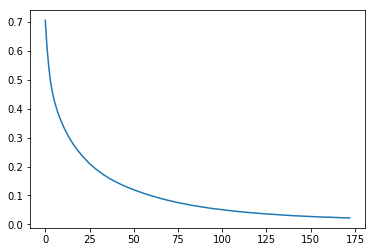

In [43]:
plt.plot(mlp.loss_curve_)

#### d. Did the training process converge and result in the best model?

The training process converged and then proceeded to overfit, this is seen by the final loss of the model being higher than the best loss

In [44]:
mlp.best_loss_, mlp.loss_

(0.022598285692443074, 0.022599943947803007)

#### e. What is the classification accuracy on the training and test datasets?

In [45]:
print(f"The classification on the training set compared to the test set is {mlp.score(Xtr_nn, ytr_nn)}/{mlp.score(Xte_nn, yte_nn)}")

The classification on the training set compared to the test set is 0.9988023952095808/0.84688995215311


### 2. Refine this network by refining is with GridSearchCV.

In this section a neural network's hyperparameters are tuned using GridSearchCV.

* `hidden_layer_size` was optimized to ensure that that a the complexity of the model was appropriate for the problem
* `activation` was optimized to ensure that the activation function of the model is capaable of representing the problm. Relu is max(0, x) and allows only relevant signals to pass through to the next layer. tanh is good when the sign of the signal is relevant but the magnitude needs to be limited. logistic is a mix of the two.
* `learning_rate` and `learning_rate_init` were used to ensure that the network had the ability to fine tune itself to find the best minima.

source: https://www.quora.com/How-should-I-choose-a-proper-activation-function-for-the-neural-network?share=1

In [46]:
params = {
    "hidden_layer_sizes": [(50), (100), (100, 100)],
    "activation": ['logistic', 'tanh', 'relu'],
    "learning_rate_init": [0.0001, 0.001, 0.1, 0.5, 1],
    "learning_rate": ["constant", "invscaling", "adaptive"]
}

gs_mlp = GridSearchCV(MLPClassifier(max_iter=1000), params, n_jobs=-1).fit(Xtr_nn, ytr_nn)

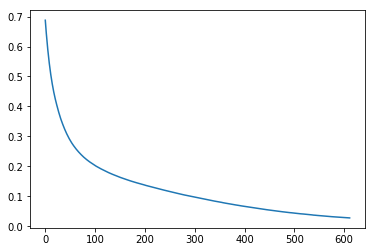

In [47]:
plt.plot(gs_mlp.best_estimator_.loss_curve_)

The neural network using GridSearchCV showed no sign of improvement over the default parameters.

In [48]:
gs_mlp.score(Xtr_nn, ytr_nn), gs_mlp.score(Xte_nn, yte_nn)

(0.9952095808383233, 0.8229665071770335)

In [49]:
print(f"the default neural network has hidden layers(s) of size {gs_mlp.best_estimator_.hidden_layer_sizes} which uses {gs_mlp.best_estimator_.activation} activations")

the default neural network has hidden layers(s) of size (100, 100) which uses tanh activations


In [50]:
print(f"the neural network was trained in {len(gs_mlp.best_estimator_.loss_curve_)} iterations")

the neural network was trained in 612 iterations


### 3. Build  another Neural Network with inputs selected from RFE with regression.

(Use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).

In [51]:
Xtr_nn_rfe, Xte_nn_rfe = rfe.transform(reg_X_train), rfe.transform(reg_X_test)
ytr_nn_rfe, yte_nn_rfe = ytr_nn, yte_nn

#### a. Did feature selection help here? Any changes in network architecture? What inputs are being used?

The inputs being used are G1 and G2, feature selection has increased performance and training time measurably, requiring only 100 epochs. The architecture used is is the default.

'train acc:0.9221556886227545 test acc: 0.8851674641148325'

'best loss: 0.1916956868343936 loss:0.1916956868343936'

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

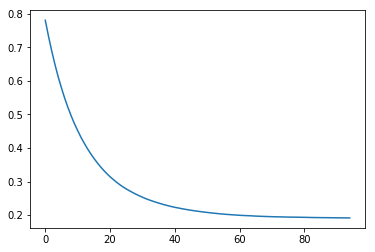

In [52]:
mlp_rfe = MLPClassifier(max_iter=1000).fit(Xtr_nn_rfe, ytr_nn_rfe)

plt.plot(mlp_rfe.loss_curve_)
display(
    f"train acc:{mlp_rfe.score(Xtr_nn_rfe, ytr_nn_rfe)} test acc: {mlp_rfe.score(Xte_nn_rfe, yte_nn_rfe)}",
    f"best loss: {mlp_rfe.best_loss_} loss:{mlp_rfe.loss_}",
    mlp_rfe
)

#### b. What is the classification accuracy on the train and test datasets? Any improvements?

In [53]:
f"train acc:{mlp_rfe.score(Xtr_nn_rfe, ytr_nn_rfe)} test acc: {mlp_rfe.score(Xte_nn_rfe, yte_nn_rfe)}"

'train acc:0.9221556886227545 test acc: 0.8851674641148325'

#### c. How many iteration are needed to train this network?

In [54]:
print(f"the model was trained in only {len(mlp_rfe.loss_curve_)} iterations")

the model was trained in only 95 iterations


#### d. Do you see any sign of over-fitting?

No, the difference between the train and test performance for the GridSearch/RFE model only approximately 4%, this is insignificant and is much lower than the 16% difference found in the pure GridSearch model.

#### e. Did the training process converge and result in the best model?

Yes, the training process converged.

#### f. Use GridSearchCV to tune the network to see whether the change in network architecture can further improve the performance.

'train acc:0.9269461077844311 test acc: 0.8755980861244019'

'best loss: 0.1914733923491039 loss:0.1959313025488057'

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [50, 100, (100, 100)], 'activation': ['logistic', 'tanh', 'relu'], 'learning_rate_init': [0.0001, 0.001, 0.1, 0.5, 1], 'learning_rate': ['constant', 'invscaling', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

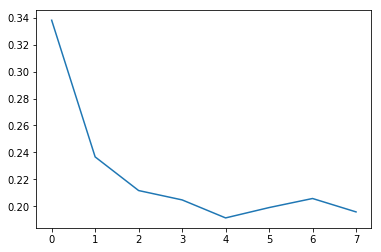

In [55]:
params = {
    "hidden_layer_sizes": [(50), (100), (100, 100)],
    "activation": ['logistic', 'tanh', 'relu'],
    "learning_rate_init": [0.0001, 0.001, 0.1, 0.5, 1],
    "learning_rate": ["constant", "invscaling", "adaptive"]
}

gs_mlp_rfe = GridSearchCV(MLPClassifier(max_iter=1000), params, n_jobs=-1).fit(Xtr_nn_rfe, ytr_nn_rfe)

plt.plot(gs_mlp_rfe.best_estimator_.loss_curve_)
display(
    f"train acc:{gs_mlp_rfe.score(Xtr_nn_rfe, ytr_nn_rfe)} test acc: {gs_mlp_rfe.score(Xte_nn_rfe, yte_nn_rfe)}",
    f"best loss: {gs_mlp_rfe.best_estimator_.best_loss_} loss:{gs_mlp_rfe.best_estimator_.loss_}",
    gs_mlp_rfe
)

In [56]:
print(f"The parameters used are the same as the those used for the earlier neural network gridsearch, for the same reasons. This model trained in {len(gs_mlp_rfe.best_estimator_.loss_curve_)} epochs and did not reach a stable minima.")

The parameters used are the same as the those used for the earlier neural network gridsearch, for the same reasons. This model trained in 8 epochs and did not reach a stable minima.


In [57]:
accuracy_overview['neural_network'] = format_accuracy_overview(yte_nn_rfe, mlp_rfe.predict(Xte_nn_rfe), [])

### 3. Using the comparison methods, Which appears to be better?

From the better model, can you identify which customers to target? Can you provide some descriptive summary of those customers?

In [58]:
print(accuracy_overview["decision_tree"]["f1"], accuracy_overview["decision_tree"]["AUC"])

print(accuracy_overview["regression"]["f1"], accuracy_overview["regression"]["AUC"])

print(accuracy_overview["neural_network"]["f1"], accuracy_overview["neural_network"]["AUC"])

0.8640776699029126 0.8660010991023998
0.896551724137931 0.8992947426268547
0.8823529411764707 0.8850064114306649


In [71]:
len(Xtr_nn[0])

49

In [59]:
accuracy_overview['regression']

{'precision': 0.91,
 'recall': 0.883495145631068,
 'f1': 0.896551724137931,
 'accuracy': 0.8995215311004785,
 'ROC': (array([0.        , 0.08490566, 1.        ]),
  array([0.        , 0.88349515, 1.        ]),
  array([2, 1, 0], dtype=int64)),
 'AUC': 0.8992947426268547,
 'most_important_features': ['G1',
  'G2',
  'failures',
  'school_THS',
  'Fjob_health']}

The modle wich performs the best is the logistic regression model. The regression model (like all other models) relies exclusively on the student's G1 and G2 scores.

---
## Task 5. Comparing Predictive Models

(4 marks)

### 1. Using the comparison methods to compare the best decsision tree model, the best regression model...

#### a. Discuss the findings led by (a) ROC Chart and Index; (b) Accuracy Score; (c) Classification Report.

In [91]:
print(f"GridSearchCV + RFE + NN Classification Accuracy: {gs_mlp_rfe.score(Xte_nn_rfe, yte_nn_rfe)}")
print("GridSearchCV + RFE + NN Classification Report\n", classification_report(yte_nn_rfe, gs_mlp_rfe.predict(Xte_nn_rfe)))

GridSearchCV + RFE + NN Classification Accuracy: 0.8755980861244019
GridSearchCV + RFE + NN Classification Report
              precision    recall  f1-score   support

          0       0.88      0.88      0.88       106
          1       0.87      0.87      0.87       103

avg / total       0.88      0.88      0.88       209



#### b. Do all the models agree on the customers' characteristics? How do they vary?

In [61]:
print(accuracy_overview["decision_tree"]["most_important_features"])
print(accuracy_overview["regression"]["most_important_features"])
print(accuracy_overview["neural_network"]["most_important_features"])

['G2', 'G1', 'Dalc', 'Fedu', 'Fjob']
['G1', 'G2', 'failures', 'school_THS', 'Fjob_health']
[]


All models agree that G2 and G1 are most important.

Decisions tree only cares about G2 and G1.

### 2. Finally, based on all models and analysis, is there a particular model you will use in decision making?

### 3. Can you summarise positives and negaitives of each modelling method based on this analysis?

#### Decision tree
**Pros:**
 - Very easy to interpret. The model can be summarized into 2 simple if then rules. As can be seen in the image at 2.2.d.
 - Is very robust. It can handle most data types. Only catagorical data has to be encoded.
 - Relatively fast training time.

**Cons:**
 - Cannot handel complicated relationship. This is the reason why the accuracy is not higher than 86% on the test data.
 - Is very sensitive to overfitting. As can be seen in the default decision tree that had a 100% accuracy on the training set while it only had a 82% accuracy on the test set.

#### Regression
**Pros:**
 - List item
 - 

**Cons:**
 - List item
 - 

#### Neural network
**Pros:**
 - High predictive accuracy
 - Can work with data which isn't linearly seperable.
 - Can scale complexity of model to suit problem
 - Training can be parrallelized

**Cons:**
 - Long training time
 - Blackbox, hard to interpret results
 - Many hyper parameters
 - Can overfit easily
 - requires appropriate preprocessing of data